In [1]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [3]:
def square_loss(a, b):
    """Square difference between two arrays"""
    return 0.5 * np.sum((a - b) ** 2)

def d_square_loss(theta, features, label):
    """Derivative of the square loss on theta"""
    return features * (theta * features - label)

def OGA(data, eta, loss=square_loss, dloss=d_square_loss, theta=None):
    """Implement the online gradient algorithm.
        data : numpy array  with the data for the entire task.
        Each data point must be a line of the array with the label as last column."""
    
    if theta is None :
        theta = np.zeros(data.shape[1] - 1) # Same size as the number of features
    predictions = []
    losses = []
    
    for line in data:
        features = line[:-1]
        label = line[-1]
        pred = np.sum(features * theta) # Create the prediction
        predictions.append(pred)
        
        # Here y_t is revealed
        l = loss(pred, label) # Calculate the loss
        losses.append(l)
        theta = theta - eta * dloss(theta, features, label)# Adjust theta
        
        
    return np.array(predictions), theta, losses
        

In [22]:
a = np.random.normal(size=(2000, 2))
b = np.random.normal(size=2)

y = np.matmul(a, b) + np.random.normal(scale=0.01, size = 2000)
data = np.column_stack((a, y))

res = OGA(data, 0.01)

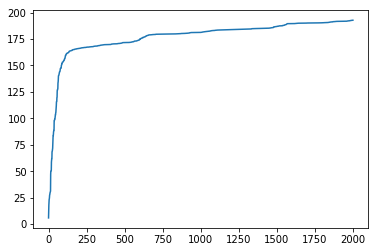

In [23]:
# We verify the OGA actually learns
plt.plot(np.cumsum(res[2]))
plt.show()

In [24]:
res[1], b

(array([-1.08142911,  2.50110037]), array([-0.94039452,  2.42295168]))

It seems that our OGA algorithm learns the right representation quite quickly, even though parameter tuning would probably yield more stability

# Implementation of the Algorithm

We implement the algorithm 4 of the paper, that is an EWA-LL for dictionary learning with an OGA as within-task algorithm

## Preparation of the data

We initialize our dictionary at a random point on the unit sphere.

In [40]:
T = 100 # Number of tasks
m = 100 # Number of samples per task
K = 2 # Number of features in the representation
d = 5 # Number of features
epsilon = 0.1

# Prepare the data
theta = np.random.uniform(-1, 1, size =(T, K)) # True regression parameters for each task
D = np.random.uniform(-1, 1, size=(K, d)) # Representation matrix
D /= np.linalg.norm(D) # normalization to be on the unit sphere

X = []
Y = []
Z = []

for t in range(T):
    # Generate the dataset
    X_t = np.random.uniform(-1, 1, size=(m, d))
    Z_t = np.matmul(D, X_t.T).T
    Y_t = np.matmul(Z_t, theta[t]) + np.random.normal(0, epsilon, m)
    X.append(X_t)
    Y.append(Y_t)
    Z.append(Z_t)



# Oracle 

We first use an oracle representation who knows D, but has to learn through the OGA each $\theta_t$

In [41]:
Z_concatenated = np.array(Z).reshape(-1, K)
Y_concatenated = np.array(Y).reshape(-1)
data_concatenated = np.column_stack((Z_concatenated, Y_concatenated))
    
# Oracle representation
# Knowing D or directly using Z is equivalent
oracle_res = OGA(data_concatenated, 0.05)

Text(0,0.5,'Cumulative Loss')

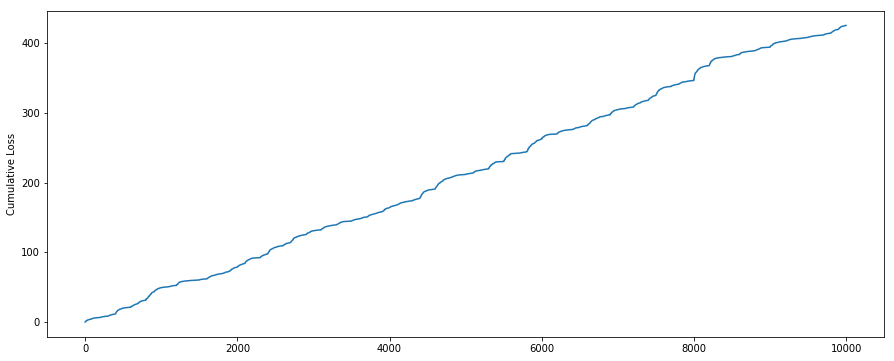

In [42]:
plt.figure(figsize=(15,6))
plt.plot(np.cumsum(oracle_res[2]))
plt.ylabel("Cumulative Loss")

Notice the "bumps" which are present at each new task, meaning that it has to learn a new $\theta$.

In [43]:
def EWA_LL_dic(X, Y, zeta, eta, sigma, N, parallel=False):
    """Implementation of the Algorithm 4 of the paper.
    X : list of features arrays, one array for each task
    Y : list of features labels, one array for each task
    zeta : learning rate for the EWA algorithm
    eta : learning rate for the within task OGA
    sigma : variance of the gaussian candidates in the Metropolis-Hastings part
    N : number of iterations of the Metropolis Hastings algorithm"""
    
    # Initialization
    # Draw a first representation on the unit sphere
    g = np.random.uniform(-1, 1, size=(K, d))
    g /= np.linalg.norm(g)
    
    # Compute the loss on the first task to compare with next candidates
    Z_0 = np.matmul(g, X[0].T).T
    data_0 = np.column_stack((Z_0, Y[0]))
    g_loss = sum(OGA(data_0, eta)[2]) # We don't save the theta as we don't want to 
    g_change = 0
    all_loss = []
    
    for i, (X_t, Y_t) in enumerate(zip(X, Y)):
        theta = 0
        Z_t = np.matmul(g, X_t.T).T # Calculate the representation with g
        data_t = np.column_stack((Z_t, Y_t))
        pred, theta, loss = OGA(data_t, eta, theta=theta)
        all_loss.append(loss)
        g_loss += sum(loss) # Suffer the loss for this task
        
        # Metropolis hastings
        for j in range(N):

            g_candidate = np.random.normal(g, sigma) # Draw a candidate
            g_candidate /= np.linalg.norm(g_candidate) 
            
            # Compute the loss of all previous tasks
            c_loss, c_theta = compute_loss(X[:i+1], Y[:i+1], g_candidate, eta)
            if np.random.rand() < min(1, np.exp(zeta * (g_loss - c_loss))):
                # print(np.exp(zeta * (g_loss - c_loss)))
                g_change +=1
                g = g_candidate # Replace the estimated representation
                g_loss = c_loss # Store the new loss
                theta = c_theta
    print("G changes : %s" % g_change)    
    return [i for j in all_loss for i in j], g

def compute_loss(X, Y, g, eta):
    total_loss = 0
    for X_t, Y_t in zip(X, Y):
        Z_t = np.matmul(g, X_t.T).T
        data_t = np.column_stack((Z_t, Y_t))
        _, theta, loss = OGA(data_t, eta)
        total_loss += sum(loss)
    return total_loss, theta

In [44]:
res, gres = EWA_LL_dic(X, Y, 0.05, 0.01, 0.1, 10)


G changes : 927


In [45]:
res1, gres = EWA_LL_dic(X, Y, 0.05, 0.01, 0.1, 1)

G changes : 92


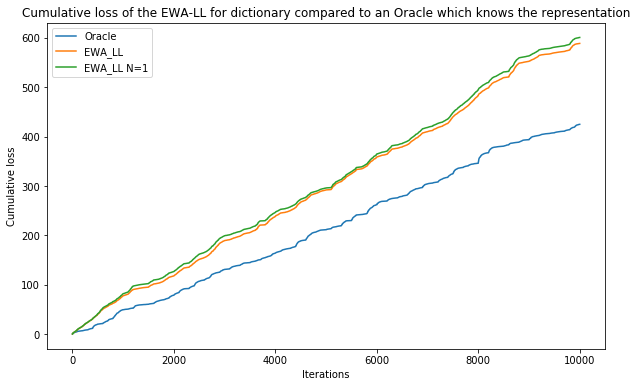

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(oracle_res[2]), label="Oracle")
plt.plot(np.cumsum(res), label="EWA_LL")
plt.plot(np.cumsum(res1), label="EWA_LL N=1")
plt.legend()
plt.title("Cumulative loss of the EWA-LL for dictionary compared to an Oracle which knows the representation")
plt.ylabel("Cumulative loss")
plt.xlabel("Iterations")
plt.savefig("results.jpg")
plt.show()

Notre algorithme semble bien apprendre la bonne représentation, même avec N=1 (au prix d'un apprentissage un peu plus lent)